In [23]:
from os.path import join as pjoin
import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import torchinfo
from  torch.optim.lr_scheduler import ReduceLROnPlateau

# Содержание

описание


# ----- Программа ------

# Констатанты

In [24]:
# папка откуда берем дата сет
MEAN_IMAGE_TRANSFORM = [0.4363, 0.4328, 0.3291]
MEAN_IMAGE_STD = [0.2129, 0.2075, 0.2038]

CLASSES = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']


In [25]:
# ===================== Конфигурация девайса
# поддержка графического процессора
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Гипер-параметры

In [26]:
EPOCHS = 20
LEARNING_RATE = 0.01
BATCH_SIZE = 128

# Изменение изображения

In [27]:
# ===================== Подготовка изображения
# Обработка входного изображения:
transform_image = transforms.Compose([
    transforms.Resize((64, 64)), 
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(MEAN_IMAGE_TRANSFORM), torch.Tensor(MEAN_IMAGE_STD))
])


# Функции

In [28]:

# считать изображения для дата сета full
def get_full_data_set():
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_image)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_image)

    train_dataloader = torch.utils.data.DataLoader(
        dataset=trainset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4,
    )
    valid_dataloader = torch.utils.data.DataLoader(
        dataset=testset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=4,
    )

    return train_dataloader, valid_dataloader

# отображение изображений
def print_result_sep_data(data, size):
    plt.figure(figsize=(10, 10))
    for index in range(size):
        plt.subplot(5, 5, index + 1)
        plt.imshow(data[index][0], cmap='gray', interpolation='none')
    plt.show()


# Работа с дата сетом

In [29]:
train_data, valid_data = get_full_data_set()
batch, _ = next(iter(train_data))

Files already downloaded and verified
Files already downloaded and verified


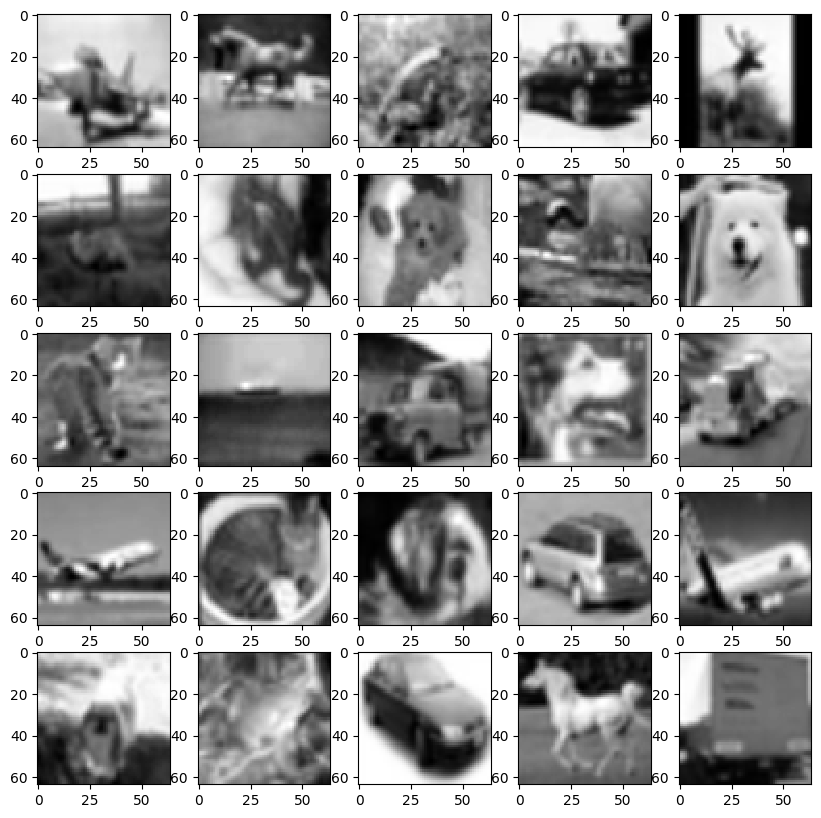

In [30]:
print_result_sep_data(batch, 25) # вывод картинок для себя

In [31]:
# определяем изначальный размер картинки для определения стартового размера слоя
imageTest = batch
print(imageTest.shape)

conv1 = nn.Conv2d(3, 6, 5)
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(6, 16, 5)

x = conv1(imageTest)
print(f'1 {x.shape}')
x = pool(x)
print(f'2 {x.shape}')
x = conv2(x)
print(f'3 {x.shape}')
x = pool(x)
print(f'4 {x.shape}')

# тогда получаем стартовый размер 
start_size_conv = 512*2 #16*13*13
print(f'start_size_conv {start_size_conv}')


torch.Size([128, 3, 64, 64])
1 torch.Size([128, 6, 60, 60])
2 torch.Size([128, 6, 30, 30])
3 torch.Size([128, 16, 26, 26])
4 torch.Size([128, 16, 13, 13])
start_size_conv 1024


# Модель

In [32]:
class ConvNet(nn.Module):    
    def __init__(self):
        # первый цвет
        super(ConvNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 5),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2,2),
            # nn.Dropout(0.2),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 5),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(2,2),
            # nn.Dropout(0.2),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 512, 5),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(2,2),
            # nn.Dropout(0.2),
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(512, 1024, 3),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.MaxPool2d(2,2),
            # nn.Dropout(0.2),
        )
        
        self.fc1 = nn.Linear(start_size_conv, 512)
        self.fc2 = nn.Linear(512, len(CLASSES))
        # self.fc3 = nn.Linear(128, len(CLASSES))
        # self.fc4 = nn.Linear(64, len(CLASSES))
        
    def forward(self, x: torch.Tensor):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        x = x.view(-1, start_size_conv) # сплющели
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        return x

# создали модель
model = ConvNet().to(device)
# print(model)
print(torchinfo.summary(model, input_size=(BATCH_SIZE, 3, 64, 64)))

Layer (type:depth-idx)                   Output Shape              Param #
ConvNet                                  [128, 10]                 --
├─Sequential: 1-1                        [128, 64, 30, 30]         --
│    └─Conv2d: 2-1                       [128, 64, 60, 60]         4,864
│    └─BatchNorm2d: 2-2                  [128, 64, 60, 60]         128
│    └─ReLU: 2-3                         [128, 64, 60, 60]         --
│    └─MaxPool2d: 2-4                    [128, 64, 30, 30]         --
├─Sequential: 1-2                        [128, 128, 13, 13]        --
│    └─Conv2d: 2-5                       [128, 128, 26, 26]        204,928
│    └─BatchNorm2d: 2-6                  [128, 128, 26, 26]        256
│    └─ReLU: 2-7                         [128, 128, 26, 26]        --
│    └─MaxPool2d: 2-8                    [128, 128, 13, 13]        --
├─Sequential: 1-3                        [128, 512, 4, 4]          --
│    └─Conv2d: 2-9                       [128, 512, 9, 9]          1,638,91

# Обучение

In [33]:
# создали потери (кроссэнтропия так как у нас много классовая классификация) тут же и совт макс
criterion = nn.CrossEntropyLoss()
# создали оптимизатор стахастический градиентный спуск - получаем скорость обучения
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, 'min')

len_steps = len(train_data)
list_loos = []
# обучение
for epoch in range(EPOCHS):
    list_loos_epoch = []
    # перегрузчик, что бы получить разные партии
    for i, (images, labels) in enumerate(train_data):
        # получаем поддержку графического процессора
        images = images.to(device)
        labels = labels.to(device)
        
        # проходим вперед
        outputs = model(images)
        
        # создаем потери
        loss = criterion(outputs, labels)
        list_loos_epoch.append(loss.item())
        # scheduler.step(loss, epoch) # lr <
        
        # чистка градиента
        optimizer.zero_grad()
        
        # обратный проход
        loss.backward()
        
        # оптимизируем шаг
        optimizer.step()
        
        print(f'Epoch [{epoch+1}/{EPOCHS}], step [{i+1}/{len_steps}], loss {loss.item():.4f}')
    
    list_loos.append(sum(list_loos_epoch) / float(len(list_loos_epoch)))

print("finish")

Epoch [1/20], step [1/391], loss 2.3115
Epoch [1/20], step [2/391], loss 2.2893
Epoch [1/20], step [3/391], loss 2.2767
Epoch [1/20], step [4/391], loss 2.2531
Epoch [1/20], step [5/391], loss 2.2374
Epoch [1/20], step [6/391], loss 2.2486
Epoch [1/20], step [7/391], loss 2.2187
Epoch [1/20], step [8/391], loss 2.2174
Epoch [1/20], step [9/391], loss 2.2057
Epoch [1/20], step [10/391], loss 2.1252
Epoch [1/20], step [11/391], loss 2.1468
Epoch [1/20], step [12/391], loss 2.1664
Epoch [1/20], step [13/391], loss 2.1392
Epoch [1/20], step [14/391], loss 2.1232
Epoch [1/20], step [15/391], loss 2.0808
Epoch [1/20], step [16/391], loss 2.1093
Epoch [1/20], step [17/391], loss 2.0577
Epoch [1/20], step [18/391], loss 2.1077
Epoch [1/20], step [19/391], loss 2.0916
Epoch [1/20], step [20/391], loss 2.1384
Epoch [1/20], step [21/391], loss 2.0632
Epoch [1/20], step [22/391], loss 2.0095
Epoch [1/20], step [23/391], loss 2.0197
Epoch [1/20], step [24/391], loss 2.0565
Epoch [1/20], step [25/39

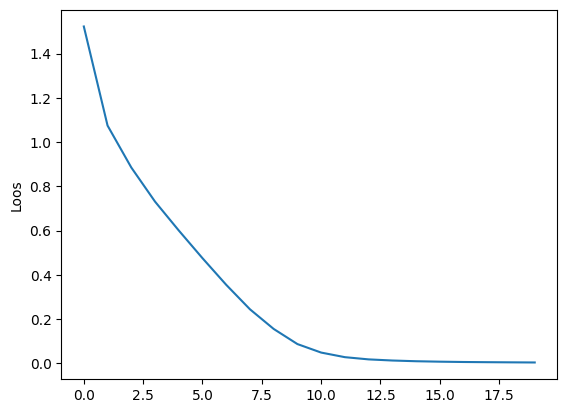

In [34]:
plt.plot([i for i in range(0, EPOCHS)], list_loos)
plt.ylabel('Loos')
plt.show()

# Проверка точности

In [35]:
# вычисление точности всей сети
list_acc = []
list_recall = []

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class__correct = [0 for i in range(len(CLASSES))]
    n_class__samples = [0 for i in range(len(CLASSES))]
    
    for images, labels in valid_data:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        # максимальное значение индекс
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(len(labels)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class__correct[label] += 1
            n_class__samples[label] += 1
            
    acc = 100 * n_correct / n_samples
    print(f'Accuracy of the network {acc} %\n\n')
    
    # вычисление точности для классов
    for i in range(len(CLASSES)):
        if (n_class__correct[i] != 0):
            acc = 100 * n_class__correct[i] / n_class__samples[i]
            print(f'Accuracy of {CLASSES[i]} {acc} %')
        else:
            acc = 0
            print(f'Accuracy of {CLASSES[i]} {acc} %')
        list_acc.append(acc)

Accuracy of the network 76.45 %


Accuracy of plane 79.4 %
Accuracy of car 87.1 %
Accuracy of bird 65.1 %
Accuracy of cat 60.4 %
Accuracy of deer 71.9 %
Accuracy of dog 68.5 %
Accuracy of frog 84.5 %
Accuracy of horse 79.9 %
Accuracy of ship 83.7 %
Accuracy of truck 84.0 %


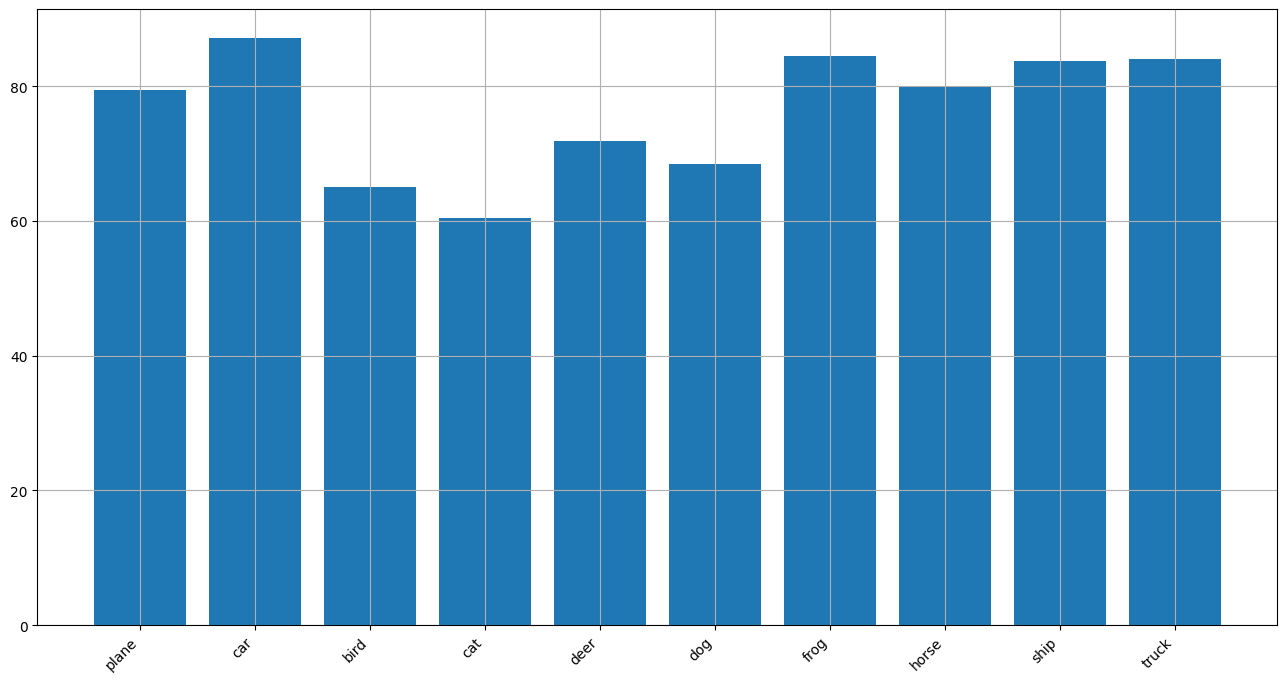

In [36]:
fig = plt.figure(figsize=(16, 8))

plt.bar(CLASSES, list_acc)
plt.grid()
plt.xticks(rotation=45, ha='right')
plt.show()